In [24]:
import os
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [25]:
def cap_Li_x(Capacity, electrode, max_cap_fullcell):  # cathode or anode
    if electrode == "cathode":
        length = 92.9 - 0.35
        width = 6.4
        Area = length * width * 2
    elif electrode == "anode":
        length = 93.4
        width = 6.6
        Area = length * width * 2
    return Area * Capacity / (1000 * max_cap_fullcell)

In [26]:
loc = r"C:\UM\Study_Material\Capstone\TVS_Motors_Data\Loading_ratio"

In [27]:
# Load data
def load_data(anode_file, cathode_file, full_cell_file):
    # loc=r'C:\UM\Study_Material\Capstone\TVS_Motors_Data\Loading_ratio'
    anode_file = os.path.join(loc, anode_file)
    cathode_file = os.path.join(loc, cathode_file)
    full_cell_file = os.path.join(loc, full_cell_file)
    anode_data_raw = pd.read_csv(anode_file, names=["Li_X", "Potential"], skiprows=1)
    cathode_data_raw = pd.read_csv(
        cathode_file, names=["Li_X", "Potential"], skiprows=1
    )
    full_cell_data_raw = pd.read_csv(
        full_cell_file, names=["Li_X", "Potential"], skiprows=1
    )
    anode_data = pd.read_csv(anode_file, names=["Li_X", "Potential"], skiprows=1)
    cathode_data = pd.read_csv(cathode_file, names=["Li_X", "Potential"], skiprows=1)
    full_cell_data = pd.read_csv(
        full_cell_file, names=["Li_X", "Potential"], skiprows=1
    )

    # max_cap_fullcell
    max_cap_fullcell = full_cell_data["Li_X"].max()
    # Update Li_X column using the cap_Li_x function
    anode_data_raw["Li_X"] = anode_data_raw["Li_X"] / anode_data_raw["Li_X"].max()
    cathode_data_raw["Li_X"] = cathode_data_raw["Li_X"] / cathode_data_raw["Li_X"].max()
    full_cell_data_raw["Li_X"] = (
        full_cell_data_raw["Li_X"] / full_cell_data_raw["Li_X"].max()
    )
    anode_data["Li_X"] = anode_data["Li_X"].apply(
        lambda x: cap_Li_x(x, "anode", max_cap_fullcell)
    )
    cathode_data["Li_X"] = cathode_data["Li_X"].apply(
        lambda x: cap_Li_x(x, "cathode", max_cap_fullcell)
    )
    full_cell_data["Li_X"] = full_cell_data["Li_X"].apply(
        lambda x: x / max_cap_fullcell
    )
    return (
        anode_data,
        cathode_data,
        full_cell_data,
        anode_data_raw,
        cathode_data_raw,
        full_cell_data_raw,
    )


# print(load_data("anode.csv","cathode.csv","full_cell.csv")[1])

In [42]:
kb = 1.380649e-23
T = 298

In [1]:
# Define the objective function with variable coefficients
def objective(x, m0, *coeffs):
    func = 0
    for i, a in enumerate(coeffs):
        # For i==0, the second term becomes zero (avoid potential issues with negative exponents)
        if i == 0:
            term = a * ((1 - 2 * x) ** (i + 1))
        else:
            term = a * (
                ((1 - 2 * x) ** (i + 1))
                - (2 * i * x * (1 - x) * ((1 - 2 * x) ** (i - 1)))
            )
        func += term
    return kb * T * np.log(x / (1 - x)) + func + m0

In [45]:
# Choose the input and output variables
def input_output(domain):
    # Load the data; assumes load_data returns the following in order:
    # anode_data, cathode_data, full_cell_data,
    # anode_data_raw, cathode_data_raw, full_cell_data_raw
    (
        anode_data,
        cathode_data,
        full_cell_data,
        anode_data_raw,
        cathode_data_raw,
        full_cell_data_raw,
    ) = load_data("anode.csv", "cathode.csv", "full_cell.csv")

    # Map domain strings to the corresponding raw data DataFrame
    raw_data = {
        "anode": anode_data_raw,
        "cathode": cathode_data_raw,
        "full_cell": full_cell_data_raw,
    }

    # Select the data for the given domain and drop rows where 'Li_X' equals 1
    data = raw_data[domain]
    data = data[data["Li_X"] != 1]
    data = data[data["Li_X"] != 0]

    # Choose the input (x) and output (y) variables
    x, y = data["Li_X"], data["Potential"]
    return x, y


# x, y = input_output(domain)

In [61]:
def optimize(domain):
    x, y = input_output(domain)
    # Create an initial guess: first parameter m0, followed by n_coeffs coefficients (here set to zero)
    if domain == "anode":
        n_coeffs = 13
    else:
        n_coeffs = 12

    initial_guess = [0] + [0] * n_coeffs

    # Perform the curve fitting
    popt, _ = curve_fit(objective, x, y, p0=initial_guess)
    # print("Fitted constants: ", popt)

    # Separate m0 and the coefficients
    m0 = popt[0]
    coeffs_opt = popt[1:]
    # for i, coeff in enumerate(coeffs_opt):
    # print(f"a{i}: {coeff}")
    return popt, x, y, m0

In [62]:
m0_values = {}
coeffs_values = {}

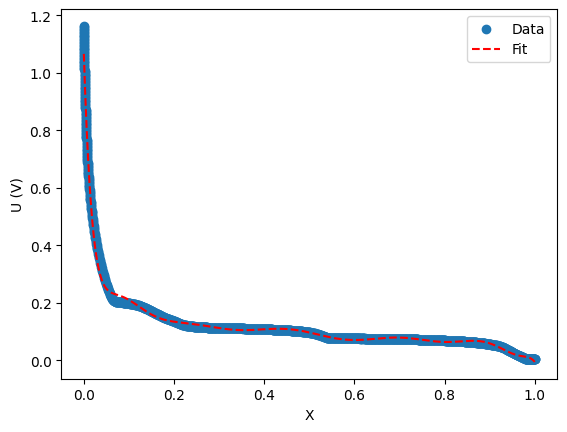

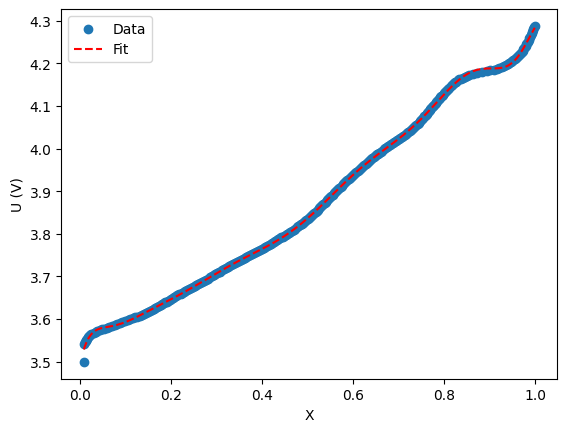

0.11787222863387316 [  0.10686728   0.04120991  -0.0697988    0.27019182   1.35141614
  -1.64799623  -5.90470322   5.4219514   13.50384686  -7.70496124
 -14.79406063   4.03252355   6.34233454]


In [63]:
for i in ["anode", "cathode"]:
    popt, x, y, m0 = optimize(i)
    # store
    m0_values[i] = m0
    coeffs_values[i] = popt[1:]
    # Plot the data and the fitted curve
    plt.scatter(x, y, label="Data")
    y_line = objective(x, *popt)
    plt.plot(x, y_line, "--", color="red", label="Fit")
    plt.xlabel("X")
    plt.ylabel("U (V)")
    plt.legend()
    plt.show()

print(m0_values["anode"], coeffs_values["anode"])

In [35]:
# Define the objective function with variable coefficients
def cathode(x):
    m0 = m0_values["cathode"]
    coeffs = coeffs_values["cathode"]
    func = 0
    for i, a in enumerate(coeffs):
        # For i==0, the second term becomes zero (avoid potential issues with negative exponents)
        if i == 0:
            term = a * ((1 - 2 * x) ** (i + 1))
        else:
            term = a * (
                ((1 - 2 * x) ** (i + 1))
                - (2 * i * x * (1 - x) * ((1 - 2 * x) ** (i - 1)))
            )
        func += term
    return kb * T * np.log(x / (1 - x)) + func + m0

In [36]:
# Define the objective function with variable coefficients
def anode(x):
    m0 = m0_values["anode"]
    coeffs = coeffs_values["anode"]
    func = 0
    for i, a in enumerate(coeffs):
        # For i==0, the second term becomes zero (avoid potential issues with negative exponents)
        if i == 0:
            term = a * ((1 - 2 * x) ** (i + 1))
        else:
            term = a * (
                ((1 - 2 * x) ** (i + 1))
                - (2 * i * x * (1 - x) * ((1 - 2 * x) ** (i - 1)))
            )
        func += term
    return kb * T * np.log(x / (1 - x)) + func + m0

In [37]:
x_data, y_data = input_output("full_cell")

In [38]:
# Define the residual function for least_squares optimization
def residuals(params, x, y):
    a, b, delta_x1, delta_x2 = params
    y_pred = cathode(a * x + delta_x1) - anode(b * x + delta_x2)
    return y - y_pred

In [39]:
# Option 1: Using minimize with MSE loss
def mse_loss(params, x, y):
    a, b, delta_x1, delta_x2 = params
    y_pred = cathode(a * x + delta_x1) - anode(b * x + delta_x2)
    return np.mean((y - y_pred) ** 2)

In [40]:
# Initial guess for parameters: [a, b, delta_x1, delta_x2]
initial_guess = [0.7, 0.65, 0.1, 0.2]

In [41]:
# Method 1: Using minimize
result_minimize = minimize(
    mse_loss, initial_guess, args=(x_data, y_data), method="L-BFGS-B"
)
optimal_params = result_minimize.x
print("Optimal parameters (minimize):", optimal_params)

c:\Program Files\Anaconda3\envs\Sudhir\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Optimal parameters (minimize): [0.88124821 0.67338648 0.10572341 0.00612092]


In [75]:
# Calculate predicted y values using the optimized parameters
a, b, delta_x1, delta_x2 = optimal_params
y_pred = cathode(a * x_data + delta_x1) - anode(b * x_data + delta_x2)

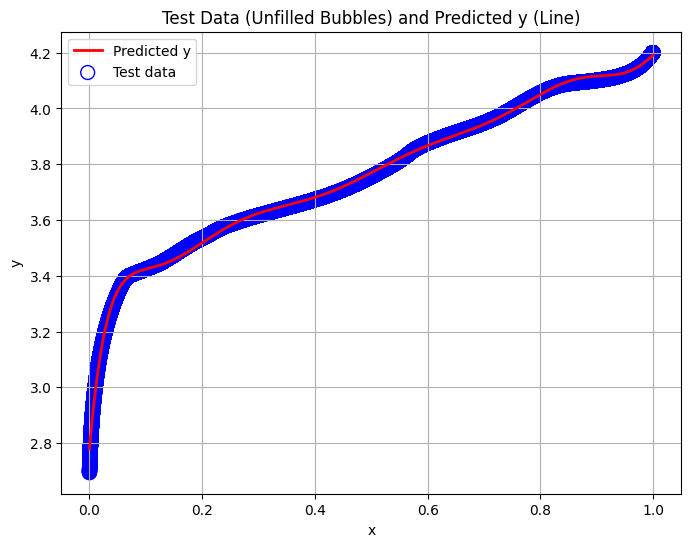

In [76]:
plt.figure(figsize=(8, 6))
plt.plot(x_data, y_pred, color="red", linewidth=2, label="Predicted y")
plt.scatter(
    x_data, y_data, facecolors="none", edgecolors="blue", s=100, label="Test data"
)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Test Data (Unfilled Bubbles) and Predicted y (Line)")
plt.legend()
plt.grid(True)
plt.show()